<a href="https://colab.research.google.com/github/Rupesh-Kataria/Quora-Duplicate-Question-Pair/blob/main/bert_fine_tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

I fine-tune BERT-based models for the sentence-pair classification task. This TensorFlow implementation leverages the Hugging face transformers and datasets libraries to download pre-trained models, enable quick research experiments and evaluation metrics.

This task is part of the semantic textual similarity/duplicate problem. You have two pair of questions and you want to model the textual interaction between them.

The dataset used in this notebook is Quora Question Pair (QQP) .You have two sentences(questions) and you want to predict if one sentence is the paraphrase of the other one. The evaluation metrics are F1 and accuracy.



In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.2 MB/s eta 0:00:00

In [2]:
import os
import matplotlib.pyplot as plt
import copy
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import load_dataset
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from datasets import Dataset, DatasetDict
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c quora-question-pairs

 94% 289M/309M [00:01<00:00, 214MB/s]
100% 309M/309M [00:01<00:00, 200MB/s]


In [4]:
!unzip /content/quora-question-pairs.zip

Archive:  /content/quora-question-pairs.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv                
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [5]:
!unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [6]:
df = pd.read_csv("./train.csv")
print(df.shape)
df.sample(10)

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
93974,93974,157013,157014,Is it a good strategy to shut your mouth with ...,Will demonetisation going to effect the rupee ...,0
19157,19157,36231,36232,Is computer science compulsory for civil engin...,Is computer science taught in civil engineering?,0
286228,286228,406762,406763,It seems rather easy to assassinate an America...,How many people would need to be assassinated ...,0
288616,288616,349589,409597,"What is the difference between 'had been', 'ha...","""if X used Y, how would it have been different...",0
177501,177501,223824,272850,What is the allusion in To Kill a Mockingbird?,"In ""To Kill a Mockingbird"", what is the exposi...",0
266304,266304,228772,22748,How does stock market works?,How do you explain stock market in layman terms?,1
170604,170604,263758,263759,What is your review of Analytics Quotient?,What's your review of Analytics quotient?,1
281556,281556,401340,401341,How difficult is it to buy a used car?,Bangladesh is removing Islam as its national r...,0
385674,385674,517831,517832,Is it wrong to have sex with a boy (husband) I...,Is it wrong to have sex with a girl I don't like?,0
221316,221316,328634,328635,What are the benefits of using Dixie Peach Pom...,What are cat whiskers for?,0


In [7]:
train = pd.read_csv("./train.csv.zip")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [9]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [10]:
# duplicate rows
df.duplicated().sum()

0

0    255027
1    149263
Name: is_duplicate, dtype: int64
0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64


<Axes: >

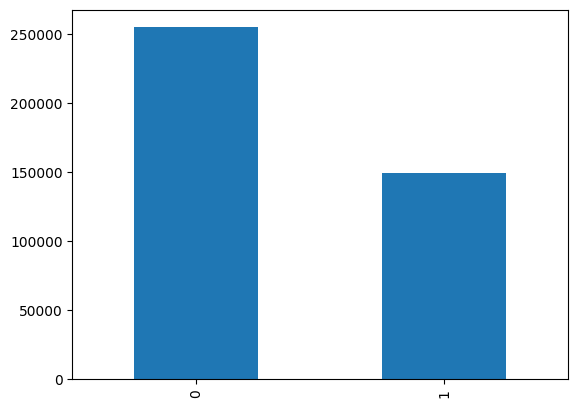

In [11]:
# Distribution of duplicate and non-duplicate questions

print(df['is_duplicate'].value_counts())
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)
df['is_duplicate'].value_counts().plot(kind='bar')

In [12]:
df.dropna(inplace=True)

In [13]:
df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)
df.sample(5)

,question1,question2,is_duplicate
197937,What is an order?,What is order?,1
37123,Wisdom: What's the difference between being in...,How do you teach children to differentiate bet...,0
312673,Is the Aligno surname Italian?,Any body know …Anand motor products …how is th...,0
342798,How do you treat pain produced by the rubber b...,I want my Mum to wear knee braces to prevent a...,0
353618,Are there parties in EU which are less interes...,My girlfriend and I were laying down naked.I r...,0


**Reading data as Huggingface dataset object**

In [14]:
train_data, val_data = train_test_split(df, test_size=0.3, random_state=1, shuffle=False)
train_data.to_csv('train_clean.csv',index=False)
val_data.to_csv('val_clean.csv',index=False)

In [15]:
dataset = load_dataset('csv', data_files={'train': './train_clean.csv',\
                                          'valid':'./val_clean.csv'},)
dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-0aa6c655ac4000b0/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'is_duplicate'],
        num_rows: 283000
    })
    valid: Dataset({
        features: ['question1', 'question2', 'is_duplicate'],
        num_rows: 121287
    })
})

In [16]:
model_checkpoint = "bert-base-cased"
batch_size = 32

In [17]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [18]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

**Sample Tokenization**

In [19]:
tokenizer(df.question1[0], df.question2[0],
                                      padding='max_length',  # Pad to max_length
                                      truncation=True,  # Truncate to max_length
                                      max_length=100,
                                      return_tensors='tf',return_token_type_ids = True)  # Return torch.Tensor objects

{'input_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[  101,  1327,  1110,  1103,  2585,  1118,  2585,  6388,  1106,
        17557,  1107,  2934,  2319,  1107,  1107,  7168,   136,   102,
         1327,  1110,  1103,  2585,  1118,  2585,  6388,  1106, 17557,
         1107,  2934,  2319,   136,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

**Tokenizer for Model Training**

In [20]:
def preprocess_function(records):
    return tokenizer(records['question1'], records['question2'], truncation=True, return_token_type_ids=True, max_length = 75)

In [21]:
pre_tokenizer_columns = dataset["train"].features

In [22]:
pre_tokenizer_columns

{'question1': Value(dtype='string', id=None),
 'question2': Value(dtype='string', id=None),
 'is_duplicate': Value(dtype='int64', id=None)}

In [23]:
encoded_dataset = dataset.map(preprocess_function, batched=True, )

Map:   0%|          | 0/283000 [00:00<?, ? examples/s]

Map:   0%|          | 0/121287 [00:00<?, ? examples/s]

In [24]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'is_duplicate', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 283000
    })
    valid: Dataset({
        features: ['question1', 'question2', 'is_duplicate', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 121287
    })
})

In [25]:
list(encoded_dataset["train"].features.keys())

['question1',
 'question2',
 'is_duplicate',
 'input_ids',
 'token_type_ids',
 'attention_mask']

In [26]:
encoded_dataset['train']['question1']

['What is the step by step guide to invest in share market in india?',
 'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
 'How can I increase the speed of my internet connection while using a VPN?',
 'Why am I mentally very lonely? How can I solve it?',
 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?',
 'Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?',
 'Should I buy tiago?',
 'How can I be a good geologist?',
 'When do you use シ instead of し?',
 'Motorola (company): Can I hack my Charter Motorolla DCX3400?',
 'Method to find separation of slits using fresnel biprism?',
 'How do I read and find my YouTube comments?',
 'What can make Physics easy to learn?',
 'What was your first sexual experience like?',
 'What are the laws to change your status from a student visa to a green card in the US, how do they compare to the immigration laws in Canada?',
 'What would a Trump presidency mean for current international 

In [27]:
encoded_dataset['train']['input_ids']

[[101,
  1327,
  1110,
  1103,
  2585,
  1118,
  2585,
  6388,
  1106,
  17557,
  1107,
  2934,
  2319,
  1107,
  1107,
  7168,
  136,
  102,
  1327,
  1110,
  1103,
  2585,
  1118,
  2585,
  6388,
  1106,
  17557,
  1107,
  2934,
  2319,
  136,
  102],
 [101,
  1327,
  1110,
  1103,
  1642,
  1104,
  19892,
  21918,
  1766,
  113,
  19892,
  1324,
  118,
  178,
  118,
  1302,
  1766,
  114,
  8549,
  136,
  102,
  1327,
  1156,
  3333,
  1191,
  1103,
  1890,
  1433,
  10566,
  1103,
  19892,
  21918,
  1766,
  113,
  19892,
  1324,
  118,
  178,
  118,
  1302,
  1766,
  114,
  9883,
  1171,
  136,
  102],
 [101,
  1731,
  1169,
  146,
  2773,
  1103,
  2420,
  1104,
  1139,
  7210,
  3797,
  1229,
  1606,
  170,
  23659,
  2249,
  136,
  102,
  1731,
  1169,
  4639,
  2420,
  1129,
  2569,
  1118,
  5871,
  12944,
  1194,
  141,
  12412,
  136,
  102],
 [101,
  2009,
  1821,
  146,
  10883,
  1304,
  12494,
  136,
  1731,
  1169,
  146,
  9474,
  1122,
  136,
  102,
  15944,
  1103,


In [28]:
tokenizer_columns = list((encoded_dataset["train"].features.keys()) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

Columns added by tokenizer: ['token_type_ids', 'input_ids', 'attention_mask']


**Data padding and batching**

In [29]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf",)


tf_train_dataset = encoded_dataset["train"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["is_duplicate"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_validation_dataset = encoded_dataset["valid"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["is_duplicate"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:385: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [30]:
# sample train batch
next(iter(tf_train_dataset))

({'input_ids': <tf.Tensor: shape=(32, 46), dtype=int64, numpy=
  array([[ 101, 1327, 2844, ...,    0,    0,    0],
         [ 101, 2181, 1122, ...,    0,    0,    0],
         [ 101, 1327, 1132, ...,    0,    0,    0],
         ...,
         [ 101, 1731, 1209, ...,  136,  102,    0],
         [ 101, 5979, 1132, ...,    0,    0,    0],
         [ 101, 1327, 1461, ...,    0,    0,    0]])>,
  'token_type_ids': <tf.Tensor: shape=(32, 46), dtype=int64, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 1, 1, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])>,
  'attention_mask': <tf.Tensor: shape=(32, 46), dtype=int64, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 1, 1, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>},
 <tf.Tensor: shape=(32,), dty

In [31]:
z=next(iter(tf_train_dataset))

In [32]:
# sample decoded string
p=tokenizer.decode(z[0]['input_ids'][0])

**Loading the model checkpoint**

In [33]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels = 2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Hyperparameters**

In [38]:
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_epochs = 1
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps, power = 2
)

opt = Adam(learning_rate=lr_scheduler)
loss = SparseCategoricalCrossentropy(from_logits=True)

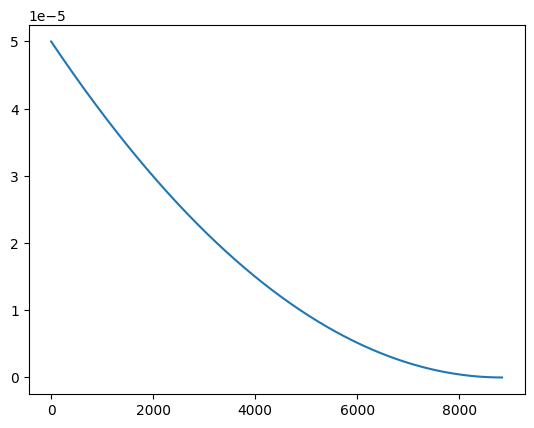

In [39]:
lr_schedule = []
for step in range(lr_scheduler.decay_steps):

    decay = (1 - (step / float(lr_scheduler.decay_steps))) ** lr_scheduler.power
    lr_schedule.append(lr_scheduler.initial_learning_rate * decay)

plt.plot(lr_schedule)

In [40]:
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [41]:
model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=1)

8844/8844 [==============================] - 4239s 474ms/step - loss: 0.1894 - accuracy: 0.9232 - val_loss: 0.2498 - val_accuracy: 0.9009


In [42]:
model.save_pretrained("./saved_model_epoch2/")

In [43]:
trained_model = TFAutoModelForSequenceClassification.from_pretrained('./saved_model_epoch2/',num_labels = 2)

Some layers from the model checkpoint at ./saved_model_epoch2/ were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./saved_model_epoch2/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [44]:
def check_similarity(question1, question2, debug = 0):
  tokenizer_output = tokenizer(question1, question2, truncation=True, return_token_type_ids=True, max_length = 75, return_tensors = 'tf')
  logits = trained_model(**tokenizer_output)["logits"]
  predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
  if predicted_class_id == 1:
    if(debug):
        print("Both questions mean the same")
    return 1
  else:
    if(debug):
        print("Both the questions are different.")
    return 0

In [45]:
check_similarity("Why are people so obsessed with cricket?", "Why are people so obsessed with football?", 1)

Both the questions are different.


0

In [46]:
check_similarity("Why are people so obsessed with cricket?", "Why do people like cricket?", 1)

Both questions mean the same


1